# Reading OOI DAS (Zarr format) from Min.IO object storage
- Yiyu Ni
- niyiyu@uw.edu
- Nov. 14, 2022

This notebook showcase a cloud-compatible DAS data storage service. The server (cascadia.ess.washington.edu) is deployed with [min.io](https://min.io) object storage service. The DAS data was originally hosted in HDF5 and was later converted to [Zarr](https://zarr.readthedocs.io/en/stable/) during this experiment.

In [ ]:
import h5py
import zarr
import matplotlib.pyplot as plt
import numpy as np
import time

In [7]:
f = h5py.File("/data/wsd04/OOI-DAS/RAW-DATA/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T033014Z.h5",'r')
# /
#  └── Acquisition
#      ├── Custom
#      └── Raw[0]
#          ├── Custom
#          │   ├── GpBits (12000,) uint8
#          │   ├── GpsStatus (12000,) uint8
#          │   ├── PpsOffset (12000,) uint32
#          │   └── SampleCount (12000,) int64
#          ├── RawData (47500, 12000) int32
#          └── RawDataTime (12000,) int64

CPU times: user 1min 16s, sys: 3.71 s, total: 1min 20s
Wall time: 1min 20s


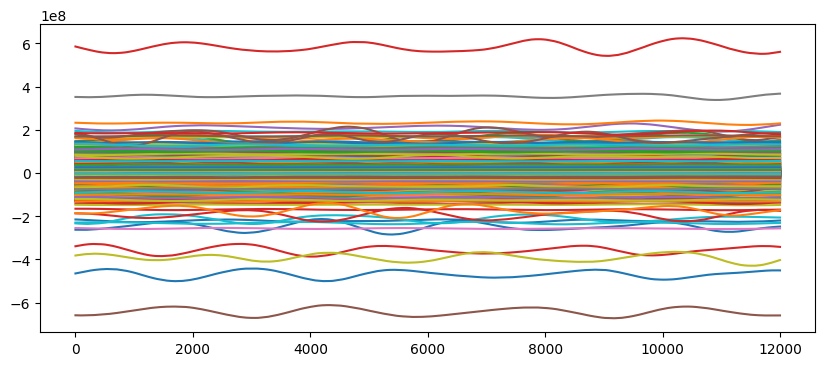

In [8]:
%%time
plt.figure(figsize = (10, 4))
# for i in [10000, 20000, 30000]:
for i in np.random.randint(0, 47500, 1000):
    plt.plot(f['/Acquisition/Raw[0]/RawData'][i, :]) # get the data from the 10000, 20000, 30000, ... channel

## write Zarr from HDF5
OOI-DAS HDF5 file could be converted to Zarr file using the code below. However, since we are using a non-object storage system, these files should be converted and copy to min.io file system, introducing disk, memory, and computation overhead. The ideal way is to write Zarr file from HDF5 directly to min.io file system. See the code in the lower section.

In [20]:
# z = zarr.open("/data/wsd04/OOI-DAS/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.zarr",'w')
# zacq = z.create_group("Acquisition")
# zcustom1 = zacq.create_group("Custom")

# zraw = zacq.create_group("Raw[0]")
# zrawdata = zraw.create_dataset("RawData", shape=(47500, 12000), chunks=(50, 12000), dtype='i4')
# zrawdata[:, :] = f['/Acquisition/Raw[0]/RawData'][:, :]

# zrawdatatime = zraw.create_dataset("RawDataTime", shape=(12000,),  dtype='i8')
# zrawdatatime[:] = f['/Acquisition/Raw[0]/RawDataTime'][:]

# zcustom2 = zraw.create_group("Custom")
# zgpbit = zcustom2.create_dataset("GpBits", shape=(12000,),  dtype='u1')
# zgpbit[:] = f['/Acquisition/Raw[0]/Custom/GpBits'][:]

# zgps = zcustom2.create_dataset("GpsStatus", shape=(12000,), dtype='u1')
# zgps[:] = f['/Acquisition/Raw[0]/Custom/GpsStatus'][:]

# zpps = zcustom2.create_dataset("PpsOffset", shape=(12000,), dtype='u4')
# zpps[:] = f['/Acquisition/Raw[0]/Custom/PpsOffset'][:]

# zspc = zcustom2.create_dataset("SampleCount", shape=(12000,), dtype='i8')
# zspc[:] = f['/Acquisition/Raw[0]/Custom/SampleCount'][:]

## write directly to min.IO object storage

In [10]:
for i in range(10):
    print(f"working on 2021-11-02T033{i}14Z.h5")
    f = h5py.File(f"/data/wsd04/OOI-DAS/RAW-DATA/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T033{i}14Z.h5",'r')
    z = zarr.open(f"s3://OOI-DAS/2021-11-02T033{i}14Z.zarr", 
                   storage_options = {
                       # for public data (anonymous access):
                        "anon": True,

                       # for private data:
    #                    "key": "MINIO-KEY",
    #                    "secret": "MINIO-SECRET",

                       "client_kwargs": {
                           # note there is no s in http
                           "endpoint_url": "http://pnwstore1.ess.washington.edu:9000"
                       }
                   }, mode = 'w')

    zacq = z.create_group("Acquisition")
    zcustom1 = zacq.create_group("Custom")

    # Raw[0] seem not working for fsspec
    # use Raw%5B0%5B? Raw0
    zraw = zacq.create_group("Raw0") 
    zrawdata = zraw.create_dataset("RawData", shape=(47500, 12000), chunks=(50, 12000), dtype='i4')
    zrawdata[:, :] = f['/Acquisition/Raw[0]/RawData'][:, :]

    zrawdatatime = zraw.create_dataset("RawDataTime", shape=(12000,),  dtype='i8')
    zrawdatatime[:] = f['/Acquisition/Raw[0]/RawDataTime'][:]

    zcustom2 = zraw.create_group("Custom")
    zgpbit = zcustom2.create_dataset("GpBits", shape=(12000,),  dtype='u1')
    zgpbit[:] = f['/Acquisition/Raw[0]/Custom/GpBits'][:]

    zgps = zcustom2.create_dataset("GpsStatus", shape=(12000,), dtype='u1')
    zgps[:] = f['/Acquisition/Raw[0]/Custom/GpsStatus'][:]

    zpps = zcustom2.create_dataset("PpsOffset", shape=(12000,), dtype='u4')
    zpps[:] = f['/Acquisition/Raw[0]/Custom/PpsOffset'][:]

    zspc = zcustom2.create_dataset("SampleCount", shape=(12000,), dtype='i8')
    zspc[:] = f['/Acquisition/Raw[0]/Custom/SampleCount'][:]
    
    f.close()

working on 2021-11-02T033014Z.h5
working on 2021-11-02T033114Z.h5
working on 2021-11-02T033214Z.h5
working on 2021-11-02T033314Z.h5
working on 2021-11-02T033414Z.h5
working on 2021-11-02T033514Z.h5
working on 2021-11-02T033614Z.h5
working on 2021-11-02T033714Z.h5
working on 2021-11-02T033814Z.h5
working on 2021-11-02T033914Z.h5


We have already written OOI-DAS into Min.IO storage in Zarr format. Here is how HDF5 and Zarr file looks like in the native XFS file system on cascadia.

In [12]:
!ls /data/wsd04/OOI-DAS/RAW-DATA/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T033*

/data/wsd04/OOI-DAS/RAW-DATA/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T033014Z.h5
/data/wsd04/OOI-DAS/RAW-DATA/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T033114Z.h5
/data/wsd04/OOI-DAS/RAW-DATA/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T033214Z.h5
/data/wsd04/OOI-DAS/RAW-DATA/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T033314Z.h5
/data/wsd04/OOI-DAS/RAW-DATA/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T033414Z.h5
/data/wsd04/OOI-DAS/RAW-DATA/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T033514Z.h5
/data/wsd04/OOI-DAS/RAW-DATA/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T033614Z.h5
/data/wsd04/OOI-DAS/RAW-DATA/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T033714Z.h5
/data/wsd04/OOI-DAS/RAW-DATA/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T033814Z.h5
/data/wsd04/OOI-DAS/RAW-DATA/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T033914Z.h5


In [14]:
!tree /data/wsd04/OOI-DAS/minioDB/OOI-DAS/2021-11-02T033* -L 3
#     |--------------------------|-------|----------------------|
#                  |                 |               |
#                path                |        file (object) name
#                               bucket name

/data/wsd04/OOI-DAS/minioDB/OOI-DAS/2021-11-02T033014Z.zarr
└── Acquisition
    ├── Custom
    └── Raw0
        ├── Custom
        ├── RawData
        └── RawDataTime
/data/wsd04/OOI-DAS/minioDB/OOI-DAS/2021-11-02T033114Z.zarr
└── Acquisition
    ├── Custom
    └── Raw0
        ├── Custom
        ├── RawData
        └── RawDataTime
/data/wsd04/OOI-DAS/minioDB/OOI-DAS/2021-11-02T033214Z.zarr
└── Acquisition
    ├── Custom
    └── Raw0
        ├── Custom
        ├── RawData
        └── RawDataTime
/data/wsd04/OOI-DAS/minioDB/OOI-DAS/2021-11-02T033314Z.zarr
└── Acquisition
    ├── Custom
    └── Raw0
        ├── Custom
        ├── RawData
        └── RawDataTime
/data/wsd04/OOI-DAS/minioDB/OOI-DAS/2021-11-02T033414Z.zarr
└── Acquisition
    ├── Custom
    └── Raw0
        ├── Custom
        ├── RawData
        └── RawDataTime
/data/wsd04/OOI-DAS/minioDB/OOI-DAS/2021-11-02T033514Z.zarr
└── Acquisition
    ├── Custom
    └── Raw0
        ├── Custom
        ├── RawData
        └── RawDataTim

Zarr uses almost the same nomenclature as HDF5 format: multiple _dataset_ are grouped by a _group_. However, HDF5 hosts one giant object on the disk, and the **.H5** file would be the minimal element you could find without using any HDF5 tools. And Zarr stores every _group_ as a folder, and every _dataset_ as an individual file, as shown above. **Zarr file is not a single file, it is folders and files grouped by their tree structure.**

## read Zarr directly from Min.IO file system

In [16]:
z = zarr.open("s3://OOI-DAS/2021-11-02T033214Z.zarr", 
               storage_options = {
                    # for public data (anonymous access):
                    "anon": True,
                   
                    # for private data:
#                    "key": "MINIO-KEY",
#                    "secret": "MINIO-SECRET",
                   "client_kwargs": {
                       "endpoint_url": "http://cascadia.ess.washington.edu:9000"
                   }
               }, mode = "r")
print(zarr.tree(z))

/
 └── Acquisition
     ├── Custom
     └── Raw0
         ├── Custom
         │   ├── GpBits (12000,) uint8
         │   ├── GpsStatus (12000,) uint8
         │   ├── PpsOffset (12000,) uint32
         │   └── SampleCount (12000,) int64
         ├── RawData (47500, 12000) int32
         └── RawDataTime (12000,) int64


CPU times: user 7.69 s, sys: 826 ms, total: 8.51 s
Wall time: 12.5 s


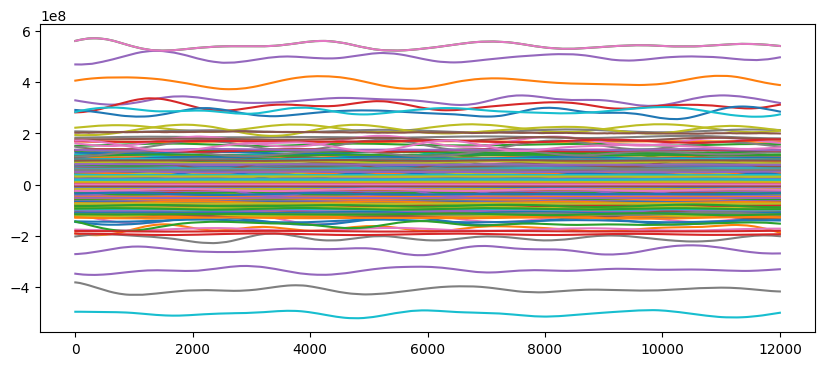

In [17]:
%%time
plt.figure(figsize = (10, 4))
for i in np.random.randint(0, 47500, 1000):
    plt.plot(z['/Acquisition/Raw0/RawData'][i, :])